In [1]:
!pip install -r requirements.txt

## DownLoad Dataset

In [1]:
import os
import requests
import zipfile

# Define the URLs for the files
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
text_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Define the directory paths to save the files
dataset_dir = "Data/Flickr8k_Dataset"
text_dir = "Data/Flickr8k_text"

# Create directories if they don't exist
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(text_dir, exist_ok=True)

# Download and save the dataset file
dataset_zip_path = os.path.join(dataset_dir, "Flickr8k_Dataset.zip")
with open(dataset_zip_path, "wb") as f:
    response = requests.get(dataset_url)
    f.write(response.content)

# Extract the dataset zip file
with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

# Download and save the text file
text_zip_path = os.path.join(text_dir, "Flickr8k_text.zip")
with open(text_zip_path, "wb") as f:
    response = requests.get(text_url)
    f.write(response.content)

# Extract the text zip file
with zipfile.ZipFile(text_zip_path, "r") as zip_ref:
    zip_ref.extractall(text_dir)

print("Files downloaded and extracted successfully.")


Files downloaded and extracted successfully.


## Note that this project used tensorflow and keras libraries for its execution

In [1]:
# Import the necessary Libraries

# from os import listdir
from pickle import dump
from pickle import load
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, concatenate
from keras.utils import plot_model
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pandas as pd
import os
from os import listdir
import re
import warnings
import string
from itertools import chain
from keras.callbacks import ModelCheckpoint
from numpy import argmax
import random
from matplotlib import pyplot as plt


from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
# import get_cnn_model, TransformerEncoderBlock, TransformerDecoderBlock, ImageCaptioningModel
from tensorflow.keras.applications import InceptionV3
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')
os.environ["KERAS_BACKEND"] = "tensorflow"

keras.utils.set_random_seed(100)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hendy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set parameters and Dataset preview

In [3]:
# Set Parameters

path_to_image = "Data/Flickr8k_Dataset/Flicker8k_Dataset"
path_to_text = "Data/Flickr8k_text" 

# Desired image dimensions
IMAGE_SIZE = (299, 299)
# Vocabulary size
VOCAB_SIZE = 10000
# Fixed length allowed for any sequence
SEQ_LENGTH = 25
# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
# Per-layer units in the feed-forward network
FF_DIM = 512
# Other training parameters
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

image_tokens=pd.read_csv(path_to_text+"/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv(path_to_text+"/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv(path_to_text+"/Flickr_8k.testImages.txt",names=["img_id"])
validation_image_names=pd.read_csv(path_to_text+"/Flickr_8k.devImages.txt",names=["img_id"])

# images dataset
images=os.listdir(path_to_image)

# Dataset Preview
print("Total number of pictures : ",len(images))
print("Images and captions dataset = ",len(image_tokens))
display(image_tokens.head())
print("Train imageset = ", len(train_image_names))
display(train_image_names.head())
print("Test imageset = ",len(test_image_names))
display(test_image_names.head())
print("Validation imageset = ",len(validation_image_names))
display(validation_image_names.head())

Total number of pictures :  8091
Images and captions dataset =  40460


img_id  \
0  1305564994_00513f9a5b.jpg#0   
1  1305564994_00513f9a5b.jpg#1   
2  1305564994_00513f9a5b.jpg#2   
3  1305564994_00513f9a5b.jpg#3   
4  1305564994_00513f9a5b.jpg#4   

                                         img_caption  
0  A man in street racer armor be examine the tir...  
1         Two racer drive a white bike down a road .  
2  Two motorist be ride along on their vehicle th...  
3  Two person be in a small race car drive by a g...  
4       Two person in race uniform in a street car .

Train imageset =  6000


img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

Test imageset =  1000


img_id
0  3385593926_d3e9c21170.jpg
1  2677656448_6b7e7702af.jpg
2   311146855_0b65fdb169.jpg
3  1258913059_07c613f7ff.jpg
4   241347760_d44c8d3a01.jpg

Validation imageset =  1000


img_id
0  2090545563_a4e66ec76b.jpg
1  3393035454_2d2370ffd4.jpg
2  3695064885_a6922f06b2.jpg
3  1679557684_50a206e4a9.jpg
4  3582685410_05315a15b8.jpg

## Load and Preprocess Data

In [4]:
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(path_to_image, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data



Instead of using the presplit training, test, and validation.
We set to split the train_size = 0.8, test_size = 0.1, validation size = 0.1


This is to ensure we allocates enought for transformer to increase and capture long-range dependencies and global context without recurrence. To fully utilize this capacity and prevent overfitting

In [5]:
# Split the captioning dataset into train and validation sets.

# caption_data (dict): Dictionary containing the mapped caption data
# train_size (float): Fraction of all the full dataset to use as training data
# shuffle (bool): Whether to shuffle the dataset before splitting

# Set train_size= 0.8, test_size= 0.1
def train_val_split(caption_data, train_size=0.8, shuffle=False):
    test_size=0.1
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    # train_size = int(len(caption_data) * train_size)
    train_end = int(len(caption_data) * train_size)
    test_end = train_end + int(len(caption_data) * test_size)

    # 4. Split into training, validation, and test sets
    training_data = {img_name: caption_data[img_name] for img_name in all_images[:train_end]}
    test_data = {img_name: caption_data[img_name] for img_name in all_images[train_end:test_end]}
    validation_data = {img_name: caption_data[img_name] for img_name in all_images[test_end:]}


    return training_data, validation_data,test_data


In [6]:
# captions_mapping <key, value>
# text_data is the features value in captions_mapping
captions_mapping, text_data = load_captions_data(path_to_text+"/Flickr8k.token.txt")

In [7]:
# Preview of the captions_mapping
n = 5
print("Display Top ",n," images with its Captions")
for key, value in dict(list(captions_mapping.items())[:n]).items():
    print(f"Image ID: {key}")
    print(f"Features: {value}")
    print("-" * 50)

Display Top  5  images with its Captions
Image ID: Data/Flickr8k_Dataset/Flicker8k_Dataset\1000268201_693b08cb0e.jpg
Features: ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
--------------------------------------------------
Image ID: Data/Flickr8k_Dataset/Flicker8k_Dataset\1001773457_577c3a7d70.jpg
Features: ['<start> A black dog and a spotted dog are fighting <end>', '<start> A black dog and a tri-colored dog playing with each other on the road . <end>', '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>', '<start> Two dogs of different breeds looking at each other on the road . <end>', '<start> Two dogs on pavement moving toward

In [8]:
# Split the dataset into training and validation sets
train_data, valid_data,test_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of test samples: ", len(test_data))


Number of training samples:  6114
Number of validation samples:  765
Number of test samples:  764


## Preprocess text

It converts the input string to lowercase and removes specific characters specified in the strip_chars variable.

Text Vectorization part involves initializing a TextVectorization layer to convert text data into numerical vectors.

In [9]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


We will generate pairs of images and corresponding captions using a tf.data.Dataset object. The pipeline consists of two steps:

Read the image from the disk
Tokenize all the five captions corresponding to the image

In [10]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

Building the model


The model consists of :
- CNN layer is used for extracting visual features from the input images 
- Transformer encoder applies self-attention that converts different parts of visual input and encodes it into a meaningful representation
- Transformer decoder generates captions based on the encoder output
- Sequential layer is used for assembling the components of the model.

In [11]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

## Define Model Architectures

Transfer learning is implicitly utilized when loading the pre-trained InceptionV3 model for extracting image features. By setting weights="imagenet", the model is initialized with weights pre-trained on the ImageNet dataset, which contains a large number of labeled images. This initialization allows the model to capture general visual features that are useful for various image-related tasks.

In [34]:
# Define model
def get_cnn_model():
    base_model = InceptionV3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")



    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )


        # return out_2
        out_1 = self.layernorm_2(inputs + attention_output_1)
        attn_output_2 = self.attention_2(out_1, out_1, out_1, attention_mask=None, training=training)
        out_2 = self.layernorm_2(out_1 + attn_output_2)
        # out_2 = self.dense_2(out_2)

        return out_2


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.encoder_input_shape = cnn_model.output_shape[1:]
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }
    
    def call(self, inputs, training=None, mask=None):
        # Pass the input through the CNN model
        img_embed = self.cnn_model(inputs)
        # Pass the embedded image through the encoder and decoder
        # (omitting the loop for multiple captions for simplicity)
        output = self.decoder(self.encoder(img_embed), training=training, mask=mask)
        return output


    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


In [35]:
# Record the results
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

class MetricTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss_values.append(logs.get('loss'))
        train_accuracy_values.append(logs.get('accuracy'))  # Use 'accuracy' instead of 'acc'
        val_loss_values.append(logs.get('val_loss'))
        val_accuracy_values.append(logs.get('val_accuracy'))  # Use 'val_accuracy' instead of 'val_acc'


In [36]:
# Model training
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)


# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# This is going to take a while so just skip this and load the model
# Compile the model 
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

## Can skip this part if you already have the model saved

In [39]:
# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, MetricTracker()],
)

# Save model weights with the correct filename format
os.makedirs("models/", exist_ok=True)
caption_model.save_weights('models/transformer_model_weights_inception.weights.h5')

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1344s 14s/step - acc: 0.1654 - loss: 31.9572 - accuracy: 0.2329 - val_accuracy: 0.3066 - val_loss: 20.2683
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1122s 12s/step - acc: 0.3112 - loss: 19.8508 - accuracy: 0.3172 - val_accuracy: 0.3336 - val_loss: 18.4762
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1125s 12s/step - acc: 0.3364 - loss: 18.2131 - accuracy: 0.3386 - val_accuracy: 0.3464 - val_loss: 17.6771
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1130s 12s/step - acc: 0.3501 - loss: 17.2598 - accuracy: 0.3514 - val_accuracy: 0.3542 - val_loss: 17.2073
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1134s 12s/step - acc: 0.3598 - loss: 16.6079 - accuracy: 0.3610 - val_accuracy: 0.3596 - val_loss: 16.8822
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1135s 12s/step - acc: 0.3667 - loss: 16.0941 - accuracy: 0.3690 - val_accuracy: 0.3647 - val_loss: 16.6164
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1136s 12s/step - acc: 0.3747 - loss: 15.6585 - accuracy: 0.3761 - val_accuracy: 0.3681 - val

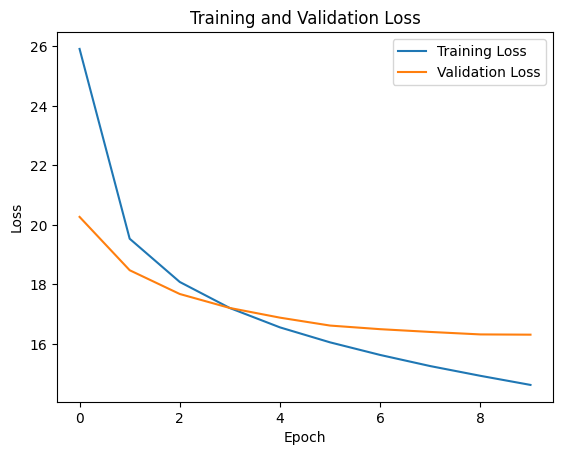

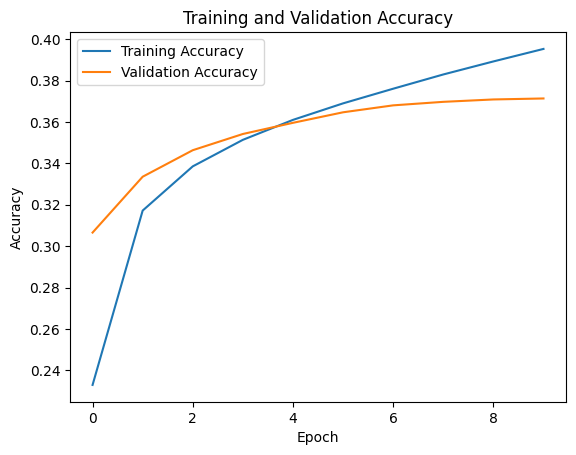

In [40]:
# Plot training and validation loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Load Model from file directory

In [41]:
# Load model weight
caption_model.load_weights('models/transformer_model_weights_inception.weights.h5')
caption_model.summary()
print("model loaded")

Model: "image_captioning_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_12 (Functional)           │ ?                           │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_5          │ ?                           │       3,155,456 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_5          │ ?                           │      14,992,656 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,247,121 (290.86 MB)

 Trainable params: 18,148,112 (69.23 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 36,296,225 (138.46 MB)

model loaded


## Evaluating the trained models on random images in testing dataset

In [42]:
# Testing the model

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

In [79]:
def generate_caption(sample_img):
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        
        # Check if the sampled_token_index exists in index_lookup
        sampled_token = index_lookup.get(sampled_token_index, "<unknown>")
        
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption



In [80]:
def evaluate_random_images(model, test_data, vectorization, num_images):
    bleu_scores = []

    # Convert dictionary view object to a list of tuples
    test_data_list = list(test_data.items())

    # Randomly select num_images images
    random_images = random.sample(test_data_list, num_images)

    for img_path, true_captions in random_images:
        # Generate predicted caption
        predicted_caption = generate_caption(img_path)

        # Calculate BLEU score
        chencherry = SmoothingFunction()
        bleu_score = sentence_bleu(true_captions, predicted_caption, smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

        # Load and display the image
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Print true caption, predicted caption, and BLEU score
        true_captions_ = [caption.replace("<start> ", "").replace(" <end>", "").strip() for caption in true_captions]
        print("True Caption:", true_captions_,"\n")
        predicted_caption_ = predicted_caption.replace("<unknown> ", "").strip()
        print("Predicted Caption:", predicted_caption_,"\n")
        print("BLEU Score:", bleu_score)
        print("=" * 50)

    # Compute average BLEU score
    if bleu_scores:
        average_bleu = sum(bleu_scores) / len(bleu_scores)
    else:
        average_bleu = 0
    return average_bleu


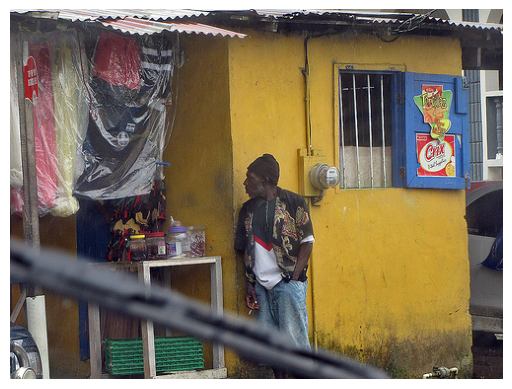

True Caption: ['A dark skinned man standing outside a small yellow building which is setup to sell items .', 'A man is standing outside a yellow building .', 'A man is standing outside of a yellow building .', 'A man standing in front of a yellow building', 'The man is standing next to a yellow building with a blue window .'] 

Predicted Caption: a man in a blue shirt is riding a bicycle on a dirt bike 

BLEU Score: 0.45160015940143106


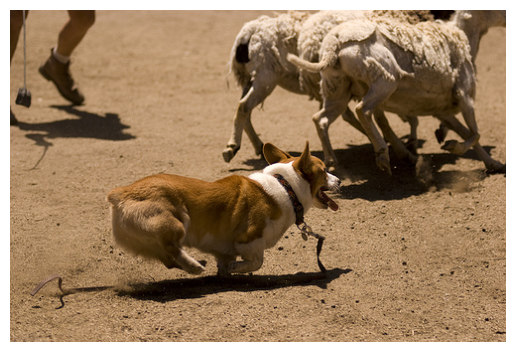

True Caption: ['A brown and white corgi trailing a leash chasing sheep .', 'A dog chasing livestock on sand .', 'A short brown and white dog chasing sheep .', 'a small tan dog herding some sheep', 'Brown and white dog , running on sand with livestock animals partially out of frame .'] 

Predicted Caption: a black and white dog is running on a dirt track 

BLEU Score: 0.7195826101964228


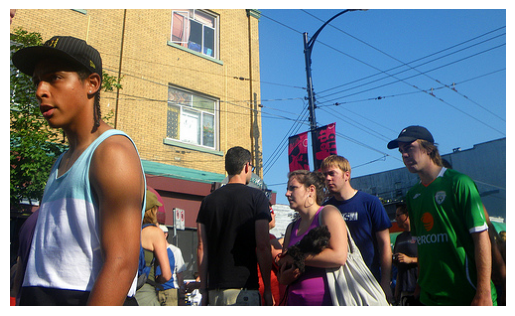

True Caption: ['A crowd of people are walking down a city street .', 'A group a people walk around the corner near a brick building .', 'A group of people stands in front of a yellow building .', 'People gather together outdoors .', 'The people walk near a brick building .'] 

Predicted Caption: a man in a red shirt and white shirt is standing on a skateboard 

BLEU Score: 0.3179400864727676


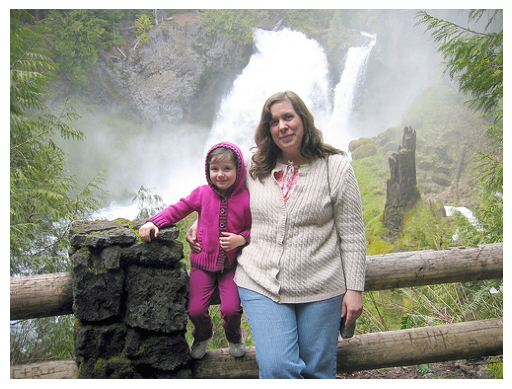

True Caption: ['A mother and daughter pose in front of a waterfall .', 'A woman and a child are sitting on a log and stone fence with a waterfall in the background .', 'A woman and a girl sitting on a fence in front of a waterfall', 'A woman and her daughter in front of a waterfall', 'A woman is sitting with a girl on a fence in front of a waterfall .'] 

Predicted Caption: a dog is running through the grass 

BLEU Score: 0.176992164297146


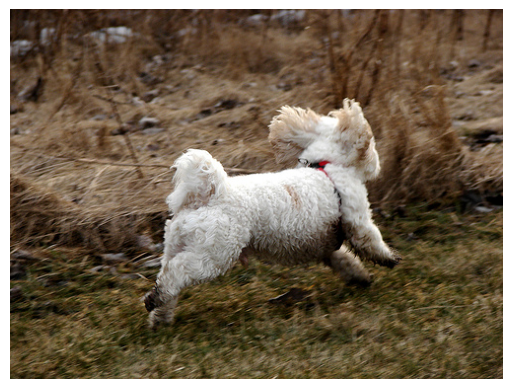

True Caption: ['A fluffy white dog runs through the woods with his ears flapping in the breeze .', 'A small white dog is running across a grassy field .', 'A white dog runs in the grass ,', 'A white dog wearing a red harness runs though the woods .', 'The little white dog wearing the red collar is running in the grass .'] 

Predicted Caption: a dog is running through a field 

BLEU Score: 0.6137926665250882


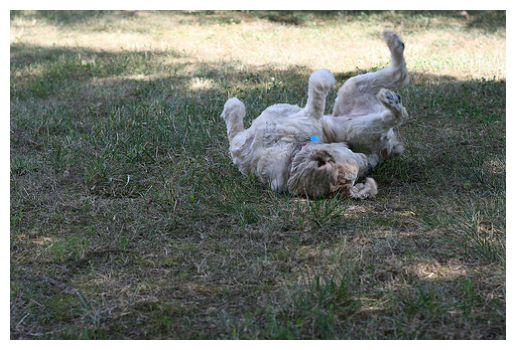

True Caption: ['A dog rolls in the grass .', 'A small white dog rolls over on the grass .', 'A tan dog rolls in the grass .', 'The grey dog is rolling on its back on the grass .', 'The yellow dog wears a blue dog tag and rolls on a green field .'] 

Predicted Caption: a brown dog is running through a field 

BLEU Score: 0.5379664103975954
Average BLEU Score on the random 6 test images: 0.46964568288174185


In [52]:
print("\n\n")
n = 6
# Calculate Average n pictures
bleu_score = evaluate_random_images(caption_model, test_data, vectorization, num_images=n)
print(f"Average BLEU Score on the random {n} test images: {bleu_score}")


## This Section is used to compares with LSTM model

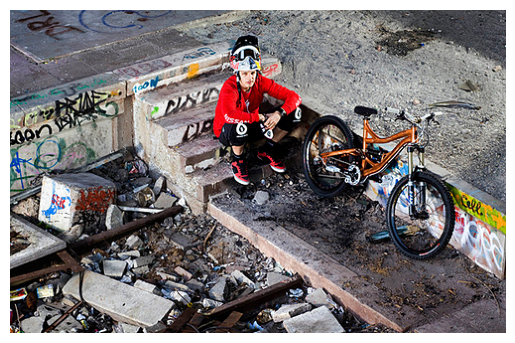

Images ID =  3613424631_3ae537624f.jpg
True Caption: ['A cyclist sits on some steps with his bike .', 'A helmeted man sits on steps with graffiti on them , and a bike nearby .', 'A man sits on the stairs next to his bike .', 'A man with his bike amid a demolished building .', 'Man with a bike sitting next to rubble .'] 

Predicted Caption: a man in a red shirt is riding a bike on a dirt bike 

BLEU Score: 0.4502882515548601


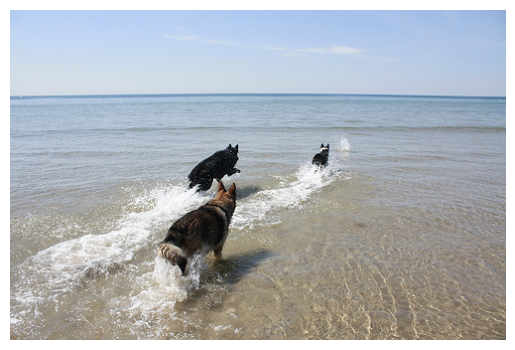

Images ID =  3630641436_8f9ac5b9b2.jpg
True Caption: ['Three dogs are running in the water on the beach .', 'Three dogs entering the ocean .', 'Three dogs rush to chase a ball thrown into the surf .', 'Three dogs walking away on the waters edge of the shore .', 'Three large dogs are playing in the water at the beach .'] 

Predicted Caption: a dog is running through the water 

BLEU Score: 0.5718304491971724


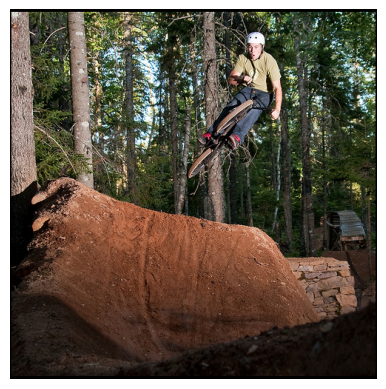

Images ID =  3640422448_a0f42e4559.jpg
True Caption: ['A bicyclist flies through the air as he encounters a tree in his path .', 'A bicyclist is jumping over a large object .', 'A man on a bike is jumping off a dirt ramp .', 'A man wearing a light brown shirt is riding a dirt bike in the woods .', 'A mountain biker is jumping his bike over a tree stump in the woods .'] 

Predicted Caption: a man in a red shirt is riding a bike on a dirt bike 

BLEU Score: 0.7702662801871221


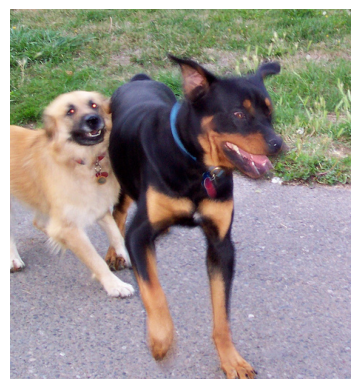

Images ID =  3651971126_309e6a5e22.jpg
True Caption: ['A black and brown dog with a tan dog on a cement path in front of grass', 'A black dog and a yellow dog are walking on asphalt next to a field of grass .', 'A blurry photo of two dogs .', 'a white dog is running behind a black dog on a paved path by some grass .', 'Two dogs walk along a path beside the grass .'] 

Predicted Caption: a black and white dog is running through the grass 

BLEU Score: 0.8443258653392445


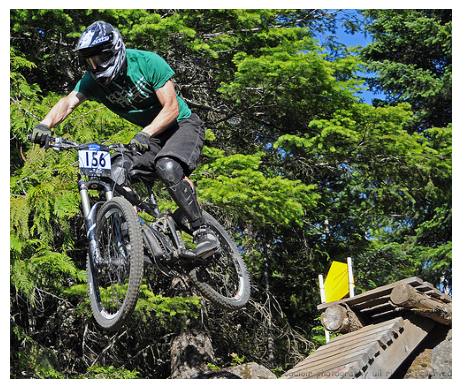

Images ID =  3696698390_989f1488e7.jpg
True Caption: ['a bicyclist wearing a helment riding down a steep ramp', 'A bike rider catches air near a ramp .', 'A BMX rider in midair .', 'A man wearing a green shirt is jumping his bicycle off a ramp .', 'Cyclist in green shirt doing trick on wooden ramp'] 

Predicted Caption: a man in a red shirt is riding a bike on a dirt bike 

BLEU Score: 0.7070251451574807


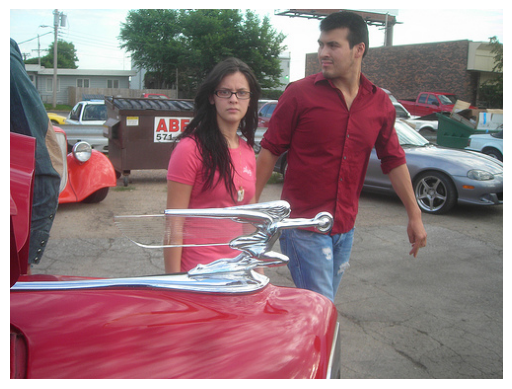

Images ID =  3725202807_12fbfdd207.jpg
True Caption: ['A couple in a parking lot .', 'A couple walks past a car in a parking lot .', 'A man and a woman are walking past a car with a fancy symbol on the front .', 'A man and a woman walk past a red car with a silver hood ornament', 'A man and woman walking next to a red car with an unusual hood ornament .'] 

Predicted Caption: a dog is running through a field 

BLEU Score: 0.2367524964740074


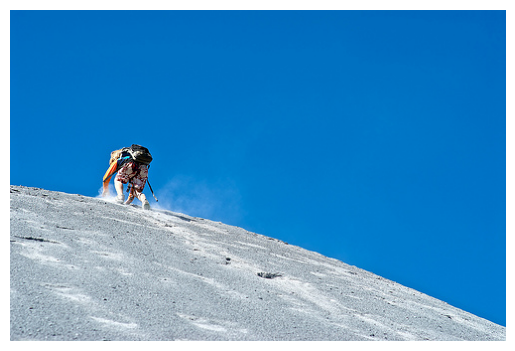

Images ID =  3745451546_fc8ec70cbd.jpg
True Caption: ['A hiker ascends a snowy hill .', 'A man reaches the top of a tall sand dune .', 'A person is hiking to the top of a hill .', 'A person walks up a white sandy hill against the blue sky .', 'The person is wearing shorts and climbing a gray sand hill under a blue sky .'] 

Predicted Caption: a person on a snowboard is jumping over a snowy hill 

BLEU Score: 0.545054153011499


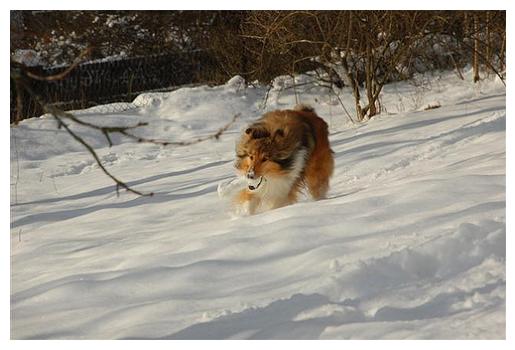

Images ID =  384577800_fc325af410.jpg
True Caption: ['A brown dog carries an object in its mouth on a snowy hillside .', 'A collie running through the snow .', 'A Sheltie dog carries a white-colored toy in its mouth as it walks across the snow .', 'Dog with a toy in the snow .', 'The dog wades through deep snow with something in its mouth .'] 

Predicted Caption: a black dog is running through the snow 

BLEU Score: 0.7465226915768447


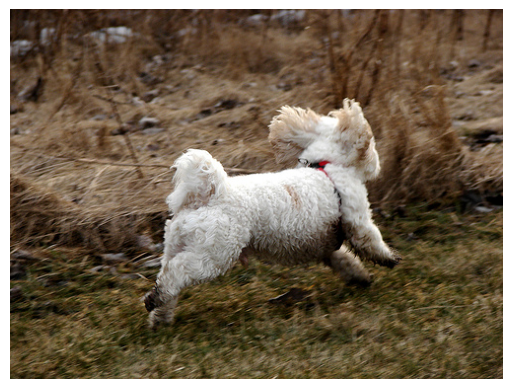

Images ID =  416106657_cab2a107a5.jpg
True Caption: ['A fluffy white dog runs through the woods with his ears flapping in the breeze .', 'A small white dog is running across a grassy field .', 'A white dog runs in the grass ,', 'A white dog wearing a red harness runs though the woods .', 'The little white dog wearing the red collar is running in the grass .'] 

Predicted Caption: a dog is running through a field 

BLEU Score: 0.6137926665250882


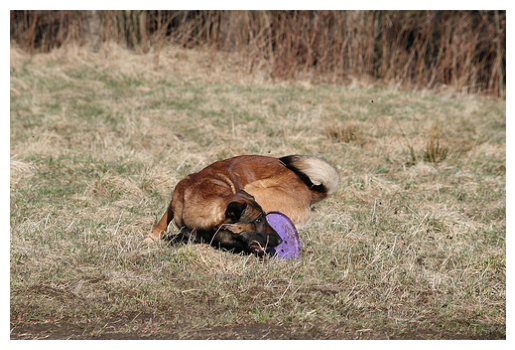

Images ID =  430173345_86388d8822.jpg
True Caption: ['A brown dog possessively grabs a purple Frisbee in a field .', 'A brown dog running to catch a Frisbee in a field of grass .', 'A brown dog with a purple Frisbee in its mouth .', 'A dog in a field with a Frisbee .', 'The dog is concerned with a purple object lying in an uncut field .'] 

Predicted Caption: a brown dog is running through the grass 

BLEU Score: 0.6260030370225997
Average BLEU Score on the some test images: 0.6111861036045919


In [99]:
def evaluate_model_on_some_images(model, test_data, vectorization):
    bleu_scores = []
    count = 0
    select_pics = [
        '3651971126_309e6a5e22.jpg',
        '3640422448_a0f42e4559.jpg',
        '3630641436_8f9ac5b9b2.jpg',
        '3613424631_3ae537624f.jpg',
        '3696698390_989f1488e7.jpg',
        '3725202807_12fbfdd207.jpg',
        '430173345_86388d8822.jpg',
        '3745451546_fc8ec70cbd.jpg',
        '384577800_fc325af410.jpg',
        '416106657_cab2a107a5.jpg'
    ]


    for img_path, true_captions in test_data.items():
        img_name = os.path.basename(img_path)  # Extracts only the file name from the full path
#         print(img_name)
        if img_name in select_pics:
            
            # Generate predicted caption
            predicted_caption = generate_caption(img_path)

            # Calculate BLEU score
            chencherry = SmoothingFunction()
            bleu_score = sentence_bleu(true_captions, predicted_caption, smoothing_function=chencherry.method1)
            bleu_scores.append(bleu_score)

            # Load and display the image
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            
            print("Images ID = ",img_name)
            # Print true caption, predicted caption, and BLEU score
            true_captions_ = [caption.replace("<start> ", "").replace(" <end>", "").strip() for caption in true_captions]
            print("True Caption:", true_captions_,"\n")
            predicted_caption_ = predicted_caption.replace("<unknown> ", "").strip()
            print("Predicted Caption:", predicted_caption_,"\n")
            print("BLEU Score:", bleu_score)
            print("=" * 50)

    # Compute average BLEU score
    if bleu_scores:
        average_bleu = sum(bleu_scores) / len(bleu_scores)
    else:
        average_bleu = 0
    return average_bleu


bleu_score = evaluate_model_on_some_images(caption_model, test_data, vectorization)
print(f"Average BLEU Score on the some test images: {bleu_score}")